<a href="https://colab.research.google.com/github/MasaAsami/D2ML/blob/main/notebooks/Sensitivity_for_DML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q econml
!pip3 install -q PySensemakr

     |████████████████████████████████| 3.3 MB 5.4 MB/s 
     |████████████████████████████████| 164 kB 57.5 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 564 kB 56.2 MB/s 


In [15]:
#@title import pkg { display-mode: "form" }

import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LogisticRegressionCV, LassoCV, Lasso, ElasticNetCV, LogisticRegression, LinearRegression
import sensemakr as smkr


# EconML imports
from econml.dml import DML, LinearDML

%matplotlib inline

# Comparing causal inference models with RCT benchmark
### DATA
- LaLonde(1986)[ "Evaluating the Econometric Evaluations of Training Programs with Experiment Data"](https://www.researchgate.net/publication/4900843_Evaluating_the_Econometric_Evaluations_of_Training_Programs_with_Experiment_Data)
- The National Supported Work Demonstration (NSW) : The interest of this experiment is whether "vocational training" (counseling and short-term work experience) affects subsequent earnings. In the dataset, the treatment variable, vocational training, is denoted by treat, and the outcome variable, income in 1978, is denoted by re78.
- Data can be downloaded at the following website:
-  https://users.nber.org/~rdehejia/data/	

|   name  |  意味  |
| :-------------: | :-------------: |
|  treat  |  介入|
|  age  |  年齢 |
|  education |  学歴  |
|  black  |  アフリカ系=1 or 0  |
|  hispanic  |  ヒスパニック系=1 or 0  |
| married  |  結婚有無 |
|  nodegree	  |  学位がない=1 |
| re74  |  74年の年収  |
|  re75  |  75年の年収  |
|  re78  |  78年の年収(アウトカム)  |


In [5]:
RCT_DATA = "http://www.nber.org/~rdehejia/data/nsw_dw.dta"
CPS_DATA = "http://www.nber.org/~rdehejia/data/cps_controls3.dta"  # cps調査で直前に無職だったものに限定

In [6]:
rct_df = pd.read_stata(RCT_DATA )
del rct_df["data_id"]

rct_df["treat"] = rct_df["treat"].astype(int)
rct_df.head()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,1,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,1,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,1,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,1,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,1,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [7]:
def p_value_color(df):
    styles = df.copy()
    styles.iloc[:, :] = ""
    idx_ = df["p_value"] <= 0.05
    styles.loc[idx_, :] = "color:purple"
    return styles

In [8]:
base_values = [col for col in rct_df.columns if col != "treat"]
_pivot = pd.pivot_table(
    rct_df,
    columns="treat",
    values=base_values,
    # margins=True,
    aggfunc=["count", np.mean, np.std],
)
_pivot["t_statistic"] = 0
_pivot["p_value"] = 0

for _value in base_values:
    _stat, _p = stats.ttest_ind(
        *rct_df.dropna(subset=[_value])
        .groupby("treat")[_value]
        .apply(lambda x: list(x)),
        equal_var=False
    )
    _pivot.loc[_value, "t_statistic"] = _stat
    _pivot.loc[_value, "p_value"] = _p

_pivot.style.apply(p_value_color, axis=None)

In [31]:
# multi regression
all_featuers = [col for col in rct_df.columns if "re78" not in col]

multi_formula = "re78 ~ "
for i, _featuer in enumerate(all_featuers):
    if i == 0:
        multi_formula += f"{_featuer}"
    else:
        multi_formula += f" + {_featuer}"
print(multi_formula)

rct_multi_regression = smf.ols(multi_formula, data=rct_df).fit()

print("RCT effect := ", rct_multi_regression.params[1])
rct_multi_regression.summary().tables[1]

re78 ~ treat + age + education + black + hispanic + married + nodegree + re74 + re75
RCT effect :=  1676.342625402626


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,785.0614,3374.969,0.233,0.816,-5848.211,7418.334
treat,1676.3426,638.682,2.625,0.009,421.056,2931.629
age,55.3167,45.284,1.222,0.223,-33.686,144.319
education,395.7343,227.415,1.740,0.083,-51.234,842.703
black,-2159.5222,1169.036,-1.847,0.065,-4457.183,138.139
hispanic,164.0327,1549.457,0.106,0.916,-2881.320,3209.386
married,-138.7253,879.728,-0.158,0.875,-1867.771,1590.321
nodegree,-70.6806,1004.387,-0.070,0.944,-2044.736,1903.374
re74,0.0821,0.077,1.061,0.289,-0.070,0.234
re75,0.0528,0.135,0.389,0.697,-0.214,0.319


In [29]:
rct_data_sense = smkr.Sensemakr(
    model = rct_multi_regression,
    treatment = "treat",
    benchmark_covariates= ["nodegree"],
    kd = [1],
)
# rct_data_sense.summary()

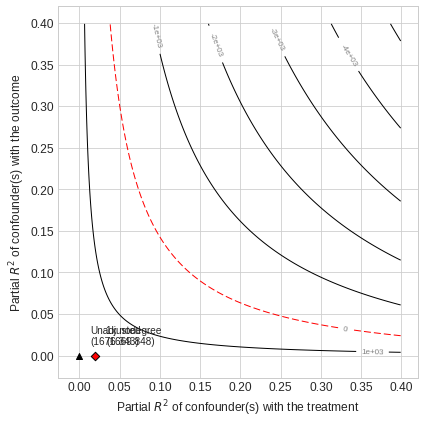

In [30]:
rct_data_sense.plot()

## Validation dataset
A validation dataset is created by excluding data from the NSW control group and instead considering non-experimental data (CPS: Current Population Survey) as the control group

In [32]:
df = pd.concat(
    [
        pd.read_stata(RCT_DATA).query("treat>0"),  # (失業者介入実験データ)nsw data の介入群のみ抽出
        pd.read_stata(CPS_DATA),  # 別のセンサスデータ
    ]
).reset_index(drop=True)

del df["data_id"]

df["treat"] = df["treat"].astype(int)
df.sample(10)

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
10,1,19.0,9.0,1.0,0.0,0.0,1.0,0.000000,0.000000,8173.908203
388,0,45.0,12.0,0.0,0.0,1.0,0.0,16559.720703,1265.758057,7987.111816
325,0,42.0,6.0,0.0,1.0,1.0,1.0,2425.572021,2832.290039,1907.744995
585,0,17.0,10.0,1.0,0.0,0.0,1.0,0.000000,0.000000,1053.619019
311,0,18.0,11.0,0.0,0.0,0.0,1.0,0.000000,3226.160889,15814.629883
0,1,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898
540,0,36.0,1.0,1.0,0.0,0.0,1.0,348.749512,0.000000,0.000000
214,0,29.0,12.0,0.0,0.0,1.0,0.0,11199.169922,8081.516113,0.000000
46,1,17.0,8.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000
371,0,18.0,11.0,1.0,0.0,0.0,1.0,1191.234009,1478.806030,3683.971924
